In [1]:
import rebound
import reboundx
import numpy as np
import sys
import time
from subprocess import call

try:
    plt.style.use('paper')
except:
    pass

In [2]:
dtfactor = 0.080901699437494756
integrator = "whfast"
order = 1
cfac = 1.#0.006
rebxintegrators = ['euler', 'rk2', 'none', 'implicit_midpoint']

In [3]:
%%time
Eerr = {}
times = {}

for rebxintegrator in rebxintegrators:
    filename = 'data2/GRcfac{0}{1}rebx{2}dt{3:.3e}order{4}'.format(cfac, integrator, rebxintegrator, dtfactor, order)
    print(filename)
    sat = rebound.SimulationArchive(filename+'.sa', rebxfilename=filename+'.rebx')
    sim0 = sat[0]
    P = sim0.particles[1].P
    rebx = reboundx.Extras.from_file(sim0, filename+'.rebx')
    gr = rebx.get_effect("gr")
    E0 = rebx.gr_hamiltonian(sim0, gr)

    Eerr[rebxintegrator], times[rebxintegrator] = np.zeros(sat.nblobs), np.zeros(sat.nblobs)
    for i, sim in enumerate(sat):
        times[rebxintegrator][i] = sim.t/sim.particles[1].P
        E = rebx.gr_hamiltonian(sim, gr)
        try:
            Eerr[rebxintegrator][i] = np.abs((E-E0)/E0)
        except:
            Eerr[rebxintegrator][i] = 0

data2/GRcfac1.0whfastrebxeulerdt8.090e-02order1


/Users/dtamayo/Documents/workspace/rebound/rebound/simulationarchive.py:83: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/dtamayo/Documents/workspace/rebound/rebound/simulationarchive.py:127: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/dtamayo/Documents/workspace/rebound/rebound/simulationarchive.py:127: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


data2/GRcfac1.0whfastrebxrk2dt8.090e-02order1
data2/GRcfac1.0whfastrebxnonedt8.090e-02order1
data2/GRcfac1.0whfastrebximplicit_midpointdt8.090e-02order1
CPU times: user 2.37 s, sys: 781 ms, total: 3.15 s
Wall time: 3.14 s


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
eps = 2e-7

labels = {'euler':'Euler', 'rk2':'RK2', 'none':'None', 'rk4':'RK4', 'implicit_midpoint':'Implicit Midpoint'}
fig, ax = plt.subplots(figsize=(12,8))
for rebxintegrator in rebxintegrators:
    ax.plot(times[rebxintegrator], Eerr[rebxintegrator], '.', label=labels[rebxintegrator], rasterized=True)
ax.plot(times[rebxintegrator], (2*np.pi)**2/2*eps**2*0.0801*times[rebxintegrator])
ax.set_xscale('log')
ax.set_yscale('log')

plt.rcParams["text.usetex"] =True
#plt.locator_params(axis='y', numticks=5)

#ax.annotate(s='', xy=(3, 1.5e-8), xytext=(3, ax.get_ylim()[1]), arrowprops=dict(width=3, facecolor='black'))
#ax.text(5, 1.e-6, r'$\epsilon_{GR}(\Delta t/T)$', fontsize=24)

ax.legend(fontsize=24, loc='lower left', markerscale=3)
ax.set_xlabel('Time (Inner Planet Orbits)', fontsize=24)
ax.set_ylabel('Relative Hamiltonian Error', fontsize=24)

fig.savefig("fig2.pdf", bbox_inches='tight')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/__init__.py:575: UserWarning: matplotlibrc text.usetex can not be used with *Agg backend unless dvipng-1.6 or later is installed on your system
  'your system' % dvipng_req)
/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/__init__.py:582: UserWarning: matplotlibrc text.usetex can not be used unless ghostscript-8.60 or later is installed on your system
  % gs_req)


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/dtamayo/.matplotlib/tex.cache/3bbc0f8d536770a62891b7cc8788c317.tex
LaTeX2e <2018-04-01> patch level 2
Babel <3.18> and hyphenation patterns for 22 language(s) loaded.
(/usr/local/texlive/2018basic/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2018basic/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.4 ^^M
       
No pages of output.
Transcript written on 3bbc0f8d536770a62891b7cc8788c317.log.




/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


RuntimeError: latex was not able to process the following string:
b'$10^{0}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/dtamayo/.matplotlib/tex.cache/21abaa2a4b4b3c07bb9296ee8f38b5a3.tex
LaTeX2e <2018-04-01> patch level 2
Babel <3.18> and hyphenation patterns for 22 language(s) loaded.
(/usr/local/texlive/2018basic/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2018basic/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.4 ^^M
       
No pages of output.
Transcript written on 21abaa2a4b4b3c07bb9296ee8f38b5a3.log.




<Figure size 864x576 with 1 Axes>

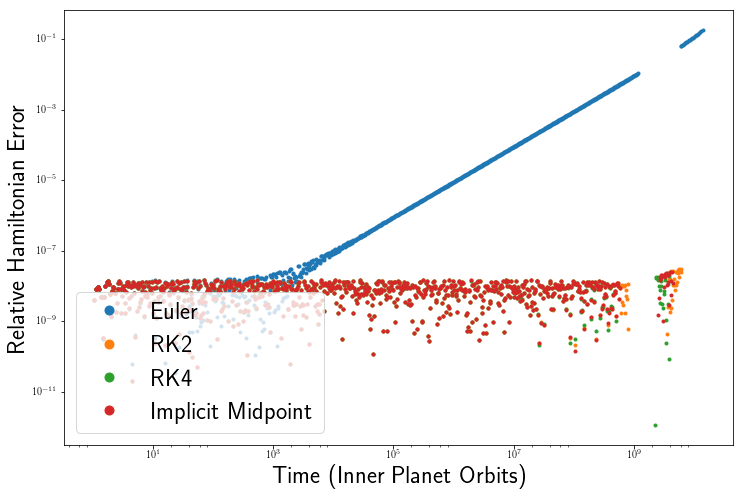

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

labels = {'euler':'Euler', 'rk2':'RK2', 'rk4':'RK4', 'implicit_midpoint':'Implicit Midpoint'}
fig, ax = plt.subplots(figsize=(12,8))
for rebxintegrator in rebxintegrators:
    ax.plot(times[rebxintegrator], Eerr[rebxintegrator], '.', label=labels[rebxintegrator], rasterized=True)
ax.set_xscale('log')
ax.set_yscale('log')

plt.rcParams["text.usetex"] =True
#plt.locator_params(axis='y', numticks=5)

#ax.annotate(s='', xy=(3, 1.5e-8), xytext=(3, ax.get_ylim()[1]), arrowprops=dict(width=3, facecolor='black'))
#ax.text(5, 1.e-6, r'$\epsilon_{GR}(\Delta t/T)$', fontsize=24)

ax.legend(fontsize=24, loc='lower left', markerscale=3)
ax.set_xlabel('Time (Inner Planet Orbits)', fontsize=24)
ax.set_ylabel('Relative Hamiltonian Error', fontsize=24)

fig.savefig("fig2.pdf", bbox_inches='tight')

In [6]:
%%time
from subprocess import call

call('rm -f test*', shell=True)
def epic(dtfactor, integrator):
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=0.93)
    sim.add(m=4.5*3.e-7, P=0.571/365.25, e=0.01)
    sim.add(m=41.*3.e-7, P=13.34/365.25, e=0.01)
    sim.move_to_com()
    sim.integrator=integrator
    sim.dt = dtfactor*sim.particles[1].P
    return sim

def addGR(sim, rebxintegrator, order, cfac):
    rebx = reboundx.Extras(sim)
    gr = rebx.add("gr")
    gr.params["c"] = 63197.8*cfac # AU/yr
    if rebxintegrator != "naive":
        rebx.integrator=rebxintegrator
        gr.operator_order = order 
        gr.force_as_operator = 1
    return rebx

dtfactor=0.080901699437494756/2
order = 1
cfac=0.008
tmax = 1.e4
rebxintegrators = ['none', 'rk2']
filename = 'test'

Eerr = {}
times = {}
Nout = 10000

for rebxintegrator in rebxintegrators:       
    sim = epic(dtfactor, integrator)
    rebx = addGR(sim, rebxintegrator, order, cfac)
    rebx.save(filename+'.rebx')
    sim.simulationarchive_snapshot(filename+rebxintegrator+'.sa')

    times = np.logspace(0, np.log10(tmax), Nout)*sim.particles[1].P
    for i, time in enumerate(times):
        sim.integrate(time, exact_finish_time=0)
        sim.simulationarchive_snapshot(filename+rebxintegrator+'.sa')

CPU times: user 2.64 s, sys: 1.3 s, total: 3.94 s
Wall time: 3.95 s


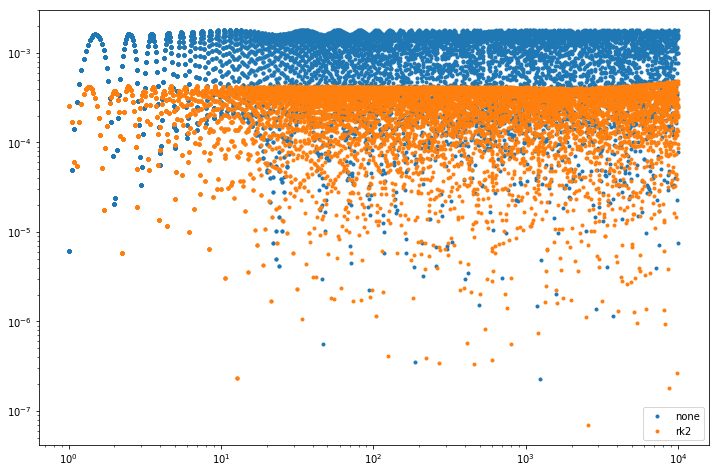

In [7]:
filename = 'test'
Eerr = {}
times = {}
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))

for rebxintegrator in rebxintegrators:
    sat = rebound.SimulationArchive(filename+rebxintegrator+'.sa', rebxfilename=filename+'.rebx')
    sim0 = sat[0]
    P = sim0.particles[1].P
    rebx = reboundx.Extras.from_file(sim0, filename+'.rebx')
    gr = rebx.get_effect("gr")
    E0 = rebx.gr_hamiltonian(sim0, gr)

    Eerr[rebxintegrator], times[rebxintegrator] = np.zeros(sat.nblobs), np.zeros(sat.nblobs)
    for i, sim in enumerate(sat):
        times[rebxintegrator][i] = sim.t/P
        E = rebx.gr_hamiltonian(sim, gr)
        try:
            Eerr[rebxintegrator][i] = np.abs((E-E0)/E0)
        except:
            Eerr[rebxintegrator][i] = 0
    ax.plot(times[rebxintegrator], Eerr[rebxintegrator], '.', label=rebxintegrator)
        
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1.e-4, 0.1])
plt.locator_params(axis='y', numticks=10)


ax.legend()